In [2]:
%pip install imblearn
%pip install pandas
%pip install shap
%pip install matplot
%pip install seaborn
%pip install altair

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
ERROR: Could not find a version that satisfies the requirement mlxtend.plotting (from versions: none)
ERROR: No matching distribution found for mlxtend.plotting
Note: you may need to restart the kernel to use updated packages.


## expand a labeled dataset to SMOTE

magnify the number of minority/exceptional cases within the sequence dataset, ideally targets the binary binned dataset.

[reference 1](<ver5-ordinal-binning-grid-searches/step 2-0, ranged clustering, with time.ipynb>)

different oversampling tools: Naive random oversampling, SMOTE, ADASYN, SMOTENC, locate the most effective, while optimizing the accuracy of a binary classifier. ~98 accuracy

a set of ensemble methods are tested then compiled into a voting classifier. ~90 accuracy

In [1]:
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN, BorderlineSMOTE, SVMSMOTE,SMOTENC, KMeansSMOTE
from imblearn.combine import SMOTEENN, SMOTETomek
from collections import Counter
import pandas as pd 

from sklearn.metrics import balanced_accuracy_score
from imblearn.ensemble import BalancedBaggingClassifier,BalancedRandomForestClassifier,RUSBoostClassifier

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import HistGradientBoostingClassifier, GradientBoostingClassifier, RandomForestClassifier, \
ExtraTreesClassifier, RandomTreesEmbedding, BaggingClassifier
from sklearn.linear_model import RidgeCV, LassoCV
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from scipy import stats

from sklearn.tree import DecisionTreeClassifier
import shap
import pandas as pd
import time
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import seaborn as sns
import altair as alt

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import  VotingClassifier 
from sklearn.model_selection import cross_val_score


IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [6]:
m2_pipeline = pd.read_csv("binary_binned_pipeline.csv")

In [7]:
m2_pipeline.columns #do this to identify the index of the categorical feature, for below setup

Index(['Unnamed: 0', 'precursor_buy_cap_pct_change',
       'precursor_ask_cap_pct_change', 'precursor_bid_vol_pct_change',
       'precursor_ask_vol_pct_change', 'sum_change', 'length',
       'surge_targets_met_pct', 'time', 'label'],
      dtype='object')

In [8]:
keepable = ['precursor_buy_cap_pct_change', 
            'precursor_ask_cap_pct_change',
            'precursor_bid_vol_pct_change', 
            'precursor_ask_vol_pct_change',
            'sum_change','length','time']

In [9]:
y = m2_pipeline['label'].values #per https://stackoverflow.com/a/73095562/12001832
X = m2_pipeline[keepable].values
# Performing the test/train split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#normalize all numeric columns
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
    

In [10]:
#set up toolsets as functions to build separate datasets, bin_Naive, bin_SMOTE, bin_ADASYN

def build_naive():  #https://imbalanced-learn.org/stable/over_sampling.html#naive-random-over-sampling
    ros = RandomOverSampler(random_state=42, sampling_strategy='minority')
    X_resampled, y_resampled = ros.fit_resample(X, y)
    print("ROS",sorted(Counter(y_resampled).items()))
    return X_resampled, y_resampled

def build_smote(): #https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTE.html#smote
    X_resampled, y_resampled = SMOTE(random_state=42 ).fit_resample(X, y)
    print("SMOTE",sorted(Counter(y_resampled).items()))
    return X_resampled, y_resampled

def build_adasyn(): #https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.ADASYN.html#adasyn
    X_resampled, y_resampled = ADASYN(random_state=42,sampling_strategy='minority').fit_resample(X, y)
    print("ADASYN",sorted(Counter(y_resampled).items()))
    return X_resampled, y_resampled

def build_borderline(): #https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.BorderlineSMOTE.html#borderlinesmote
    X_resampled, y_resampled = BorderlineSMOTE(random_state=42,sampling_strategy='minority').fit_resample(X, y)
    print("BORDERLINE",sorted(Counter(y_resampled).items())) 
    return X_resampled, y_resampled

def build_smotenc(): #https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTENC.html#smotenc
    smote_nc = SMOTENC( random_state=42,sampling_strategy='minority')
    X_resampled, y_resampled = smote_nc.fit_resample(X, y)
    print("SMOTENC",sorted(Counter(y_resampled).items()))
    return X_resampled, y_resampled

def build_svmsmote():
    sm = SVMSMOTE(random_state=42)
    X_res, y_res = sm.fit_resample(X, y)
    print("SVMSMOTE",'Resampled dataset shape %s' % Counter(y_res))
    return X_res, y_res

def build_kmsmote(): #https://imbalanced-learn.org/stable/combine.html#combination-of-over-and-under-sampling
    m = KMeansSMOTE( random_state=42,sampling_strategy='minority')
    X_res, y_res = m.fit_resample(X, y)
    # Find the number of new samples in the middle blob
    n_res_in_middle = ((X_res[:, 0] > -5) & (X_res[:, 0] < 5)).sum()
    print("KMSMOTE","Samples in the middle blob: %s" % n_res_in_middle)
    return X_res, y_res

def build_smoteenn():
    smote_enn = SMOTEENN(random_state=42,sampling_strategy='minority')
    X_resampled, y_resampled = smote_enn.fit_resample(X, y)
    print("SMOTEENN",sorted(Counter(y_resampled).items()))
    return X_resampled, y_resampled

def build_smotetomek():
    smote_tomek = SMOTETomek(random_state=42,sampling_strategy='minority')
    X_resampled, y_resampled = smote_tomek.fit_resample(X, y)
    print("SMOTETOMEK",sorted(Counter(y_resampled).items()))
    return X_resampled, y_resampled

### take optimal classifier parameters and technique

In [11]:
def getBestClassifier(oversampler, dataset):   #'kmsmote', build_svmsmote(source)
    classifiers = [  # Define the classifiers and their respective hyperparameters
        LogisticRegression(),
        BernoulliNB(),
        KNeighborsClassifier(),
    ]
    params = {
        'LogisticRegression':{'C': [0.1, 1, 10], 'penalty':['l1','l2','elasticnet','None'], 'multi_class':['ovr','auto'],\
                              'random_state':[42]},
        'BernoulliNB':{'fit_prior':[True, False]},
        'KNeighborsClassifier':{'n_neighbors':[3,4,5,6,7,8], 'algorithm':['auto'], 'n_jobs':[1,2,3,4]}
    }
    comparative = []
    # Perform the grid search
    for clf in classifiers:
        name = clf.__class__.__name__
        if name in params:
            grid_search = GridSearchCV(clf, params[name], cv=5)
            grid_search.fit(X_train_scaled, y_train)
            
            print(f"Best parameters for {name}: {grid_search.best_params_}")
            accuracy = grid_search.score(X_test, y_test)
            
            dict = {"classifier":name, "best_params":grid_search.best_params_, "accuracy":accuracy, "oversampler":oversampler}
            comparative.append(dict)
    return(comparative)

## trigger the search mechanism, per SMOTE method

loop through each oversampled dataset, then run the classifier search on that set, outlining each set, before hand

for each set, run the classifier search

In [ ]:

source = 'binary_binned_pipeline.csv'
resultSet = []
resultSet.append(getBestClassifier('naive', build_naive()))  #many rows
resultSet.append(getBestClassifier('smote', build_smote()))
resultSet.append(getBestClassifier('adasyn', build_adasyn()))
resultSet.append(getBestClassifier('borderline', build_borderline()))
# resultSet.append(getBestClassifier('smotenc', build_smotenc()))
resultSet.append(getBestClassifier('svmsmote', build_svmsmote()))
# resultSet.append(getBestClassifier('kmsmote', build_kmsmote()))
resultSet.append(getBestClassifier('smoteenn', build_smoteenn()))
resultSet.append(getBestClassifier('smotetomek', build_smotetomek()))

optimals = pd.DataFrame(resultSet)

In [13]:
optimals

,0,1,2
0,"{'classifier': 'LogisticRegression', 'best_par...","{'classifier': 'BernoulliNB', 'best_params': {...","{'classifier': 'KNeighborsClassifier', 'best_p..."
1,"{'classifier': 'LogisticRegression', 'best_par...","{'classifier': 'BernoulliNB', 'best_params': {...","{'classifier': 'KNeighborsClassifier', 'best_p..."
2,"{'classifier': 'LogisticRegression', 'best_par...","{'classifier': 'BernoulliNB', 'best_params': {...","{'classifier': 'KNeighborsClassifier', 'best_p..."
3,"{'classifier': 'LogisticRegression', 'best_par...","{'classifier': 'BernoulliNB', 'best_params': {...","{'classifier': 'KNeighborsClassifier', 'best_p..."
4,"{'classifier': 'LogisticRegression', 'best_par...","{'classifier': 'BernoulliNB', 'best_params': {...","{'classifier': 'KNeighborsClassifier', 'best_p..."
5,"{'classifier': 'LogisticRegression', 'best_par...","{'classifier': 'BernoulliNB', 'best_params': {...","{'classifier': 'KNeighborsClassifier', 'best_p..."
6,"{'classifier': 'LogisticRegression', 'best_par...","{'classifier': 'BernoulliNB', 'best_params': {...","{'classifier': 'KNeighborsClassifier', 'best_p..."


In [26]:
# print_dict = lambda x: print(x)

# # Apply the lambda function to each row of the data frame
# optimals.applymap(print_dict)

[pitfalls of oversampling](https://imbalanced-learn.org/stable/common_pitfalls.html#data-leakage)

## sampling based ensemble methods

score each, can you combine into a voter?

[validation curve model selection](https://imbalanced-learn.org/stable/auto_examples/model_selection/plot_validation_curve.html#plotting-validation-curves)

In [15]:
# balanced bagger

bbc = BalancedBaggingClassifier(base_estimator=LogisticRegression(),
                                sampling_strategy='auto',
                                replacement=False,
                                random_state=42)
bbc.fit(X_train_scaled, y_train)
y_pred = bbc.predict(X_test)
balanced_accuracy_score(y_test, y_pred)

`base_estimator` was renamed to `estimator` in version 0.10 and will be removed in 0.12.


0.5

In [16]:
#balanced tree estimator
brf = BalancedRandomForestClassifier(
    n_estimators=100, random_state=42, sampling_strategy="all", replacement=True
)
brf.fit(X_train_scaled, y_train)
y_pred = brf.predict(X_test)
balanced_accuracy_score(y_test, y_pred)

0.5864746945898779

In [17]:
rusboost = RUSBoostClassifier(n_estimators=200, algorithm='SAMME.R',
                              random_state=42)
rusboost.fit(X_train_scaled, y_train)
y_pred = rusboost.predict(X_test)
balanced_accuracy_score(y_test, y_pred)

0.5

In [19]:

X = m2_pipeline[keepable].values  #.drop(columns=['label']).values #per https://stackoverflow.com/a/73095562/12001832
y = m2_pipeline['label'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#normalize all numeric columns
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
vc = VotingClassifier(estimators=[('bbc',bbc),('brf',brf),('rusboost',rusboost)], voting='soft')#  , weights=weights) 
# #fit all, voting classifier scoring
for clf, label in zip([bbc,brf,rusboost,vc], ['BalancedBaggingClassifier','BalancedRandomForestClassifier','RUSBoostClassifier','Voting']):
    scores = cross_val_score(clf, X_train_scaled, y_train, scoring='accuracy', cv=25)
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))

`base_estimator` was renamed to `estimator` in version 0.10 and will be removed in 0.12.
`base_estimator` was renamed to `estimator` in version 0.10 and will be removed in 0.12.
`base_estimator` was renamed to `estimator` in version 0.10 and will be removed in 0.12.
`base_estimator` was renamed to `estimator` in version 0.10 and will be removed in 0.12.
`base_estimator` was renamed to `estimator` in version 0.10 and will be removed in 0.12.
`base_estimator` was renamed to `estimator` in version 0.10 and will be removed in 0.12.
`base_estimator` was renamed to `estimator` in version 0.10 and will be removed in 0.12.
`base_estimator` was renamed to `estimator` in version 0.10 and will be removed in 0.12.
`base_estimator` was renamed to `estimator` in version 0.10 and will be removed in 0.12.
`base_estimator` was renamed to `estimator` in version 0.10 and will be removed in 0.12.
`base_estimator` was renamed to `estimator` in version 0.10 and will be removed in 0.12.
`base_estimator` was 

Accuracy: 0.82 (+/- 0.05) [BalancedBaggingClassifier]
Accuracy: 0.77 (+/- 0.03) [BalancedRandomForestClassifier]
Accuracy: 0.88 (+/- 0.06) [RUSBoostClassifier]


`base_estimator` was renamed to `estimator` in version 0.10 and will be removed in 0.12.
`base_estimator` was renamed to `estimator` in version 0.10 and will be removed in 0.12.
`base_estimator` was renamed to `estimator` in version 0.10 and will be removed in 0.12.
`base_estimator` was renamed to `estimator` in version 0.10 and will be removed in 0.12.
`base_estimator` was renamed to `estimator` in version 0.10 and will be removed in 0.12.
`base_estimator` was renamed to `estimator` in version 0.10 and will be removed in 0.12.
`base_estimator` was renamed to `estimator` in version 0.10 and will be removed in 0.12.
`base_estimator` was renamed to `estimator` in version 0.10 and will be removed in 0.12.
`base_estimator` was renamed to `estimator` in version 0.10 and will be removed in 0.12.
`base_estimator` was renamed to `estimator` in version 0.10 and will be removed in 0.12.
`base_estimator` was renamed to `estimator` in version 0.10 and will be removed in 0.12.
`base_estimator` was 

Accuracy: 0.82 (+/- 0.03) [Voting]


## voting classifier error report

[0 1]


`base_estimator` was renamed to `estimator` in version 0.10 and will be removed in 0.12.


              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1146
           1       1.00      0.00      0.00        20

    accuracy                           0.98      1166
   macro avg       0.99      0.50      0.50      1166
weighted avg       0.98      0.98      0.97      1166



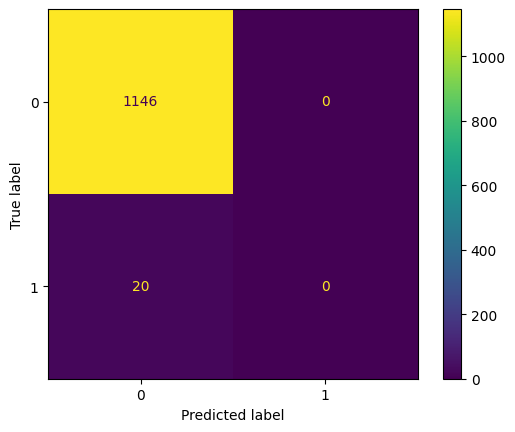

In [37]:
labels_ = m2_pipeline['label'].unique()
print(labels_)
# X_test_scaled = scaler.fit_transform(X_test)
vc.fit(X_train_scaled,y_train)

y_pred_vc = vc.predict(X_test)
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_vc, labels=labels_)

print(classification_report(y_test, y_pred_vc,zero_division=1))

## voting classifier classifier report (error reporting part 2)

In [36]:
# print(classification_report(y_test, y_pred_vc,zero_division=1))

## binary classifier error reporting

In [28]:
print_dict = lambda x: print(x)

# Apply the lambda function to each row of the data frame
optimals.applymap(print_dict)

{'classifier': 'LogisticRegression', 'best_params': {'C': 0.1, 'multi_class': 'ovr', 'penalty': 'l2', 'random_state': 42}, 'accuracy': 0.9828473413379074, 'oversampler': 'naive'}
{'classifier': 'LogisticRegression', 'best_params': {'C': 0.1, 'multi_class': 'ovr', 'penalty': 'l2', 'random_state': 42}, 'accuracy': 0.9828473413379074, 'oversampler': 'smote'}
{'classifier': 'LogisticRegression', 'best_params': {'C': 0.1, 'multi_class': 'ovr', 'penalty': 'l2', 'random_state': 42}, 'accuracy': 0.9828473413379074, 'oversampler': 'adasyn'}
{'classifier': 'LogisticRegression', 'best_params': {'C': 0.1, 'multi_class': 'ovr', 'penalty': 'l2', 'random_state': 42}, 'accuracy': 0.9828473413379074, 'oversampler': 'borderline'}
{'classifier': 'LogisticRegression', 'best_params': {'C': 0.1, 'multi_class': 'ovr', 'penalty': 'l2', 'random_state': 42}, 'accuracy': 0.9828473413379074, 'oversampler': 'svmsmote'}
{'classifier': 'LogisticRegression', 'best_params': {'C': 0.1, 'multi_class': 'ovr', 'penalty': 

DataFrame.applymap has been deprecated. Use DataFrame.map instead.


,0,1,2
0,None,None,None
1,None,None,None
2,None,None,None
3,None,None,None
4,None,None,None
5,None,None,None
6,None,None,None


### logistic regression fit, predict and error reporting

0.9828473413379074
[0 1]
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1146
           1       1.00      0.00      0.00        20

    accuracy                           0.98      1166
   macro avg       0.99      0.50      0.50      1166
weighted avg       0.98      0.98      0.97      1166



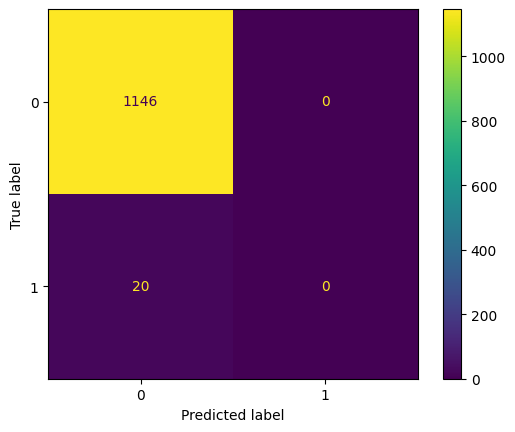

In [40]:
logreg = LogisticRegression(C=0.1, multi_class='ovr', penalty='l2', random_state=42)
logreg.fit(X_train_scaled, y_train)

y_pred_lr = logreg.predict(X_test)

accuracy_lr = accuracy_score(y_test, y_pred_lr)
print(accuracy_lr)

labels_ = m2_pipeline['label'].unique()
print(labels_)
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_lr, labels=labels_)

print(classification_report(y_test, y_pred_lr,zero_division=1))

### Naive Bayes (Bernouilli) classifier accuracy and error report

0.9828473413379074
[0 1]
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1146
           1       1.00      0.00      0.00        20

    accuracy                           0.98      1166
   macro avg       0.99      0.50      0.50      1166
weighted avg       0.98      0.98      0.97      1166



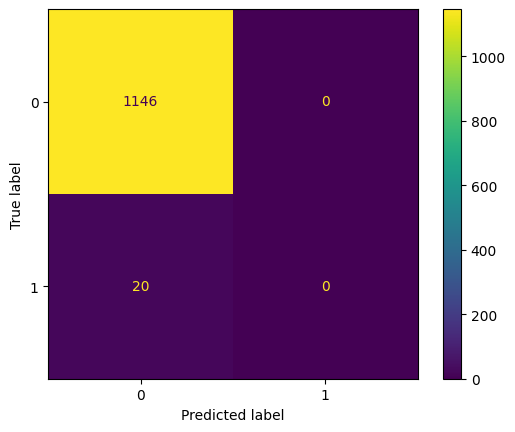

In [42]:
bnb = BernoulliNB(fit_prior=True)
bnb.fit(X_train_scaled, y_train)

y_pred_nb = bnb.predict(X_test)

accuracy_nb = accuracy_score(y_test, y_pred_nb)
print(accuracy_nb)

labels_ = m2_pipeline['label'].unique()
print(labels_)
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_nb, labels=labels_)

print(classification_report(y_test, y_pred_nb,zero_division=1))

### KN Neighbors Classifier error and classification report

0.9828473413379074
[0 1]
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1146
           1       1.00      0.00      0.00        20

    accuracy                           0.98      1166
   macro avg       0.99      0.50      0.50      1166
weighted avg       0.98      0.98      0.97      1166



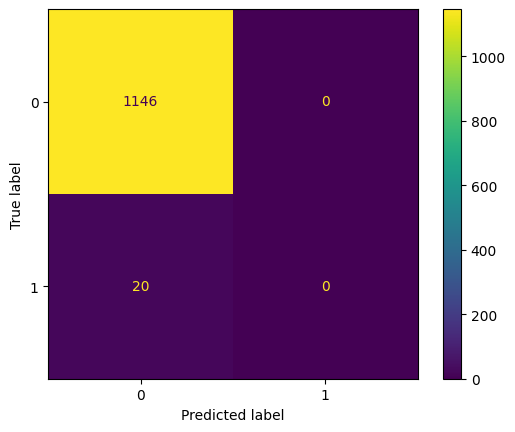

In [43]:
knn = KNeighborsClassifier(algorithm='auto', n_jobs=1, n_neighbors=6)
knn.fit(X_train_scaled, y_train)

y_pred_knn = knn.predict(X_test)

accuracy_knn = accuracy_score(y_test, y_pred_knn)
print(accuracy_knn)

labels_ = m2_pipeline['label'].unique()
print(labels_)
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_knn, labels=labels_)

print(classification_report(y_test, y_pred_knn ,zero_division=1))